In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.HH.HH import HHbbWWDoubleLeptonGenDataset,HHbbWWDoubleLeptonRecoDataset
from memflow.read_data import utils
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
gen_data = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root',
    ],
    treenames = [
        'gen_HH;1',
    ],
    lazy = True,
    # N = 1000,
)

print (gen_data)

Data object
Loaded branches:
   ... file: 1589994
   ... sample: 1589994
   ... tree: 1589994
Branch in files not loaded:
   ... H1_E
   ... H1_Px
   ... H1_Py
   ... H1_Pz
   ... H1_eta
   ... H1_idx
   ... H1_mass
   ... H1_pdgId
   ... H1_phi
   ... H1_pt
   ... H1_sum_E
   ... H2_E
   ... H2_Px
   ... H2_Py
   ... H2_Pz
   ... H2_eta
   ... H2_idx
   ... H2_mass
   ... H2_pdgId
   ... H2_phi
   ... H2_pt
   ... H2_sum_E
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12

In [ ]:
gen_dataset = HHbbWWDoubleLeptonGenDataset(
    data = gen_data,
    selection = [
        'leptons',
        'bquarks',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print (gen_dataset)

Selecting 1519507 events out of 1589994


In [ ]:
print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [ ]:
loader_gen = DataLoader(
    gen_dataset,
    batch_size = 32,
)
batch = next(iter(loader_gen))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
reco_data = RootData(
    files = gen_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = gen_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 8,
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)
print (reco_data)


In [ ]:
reco_dataset = HHbbWWDoubleLeptonRecoDataset(
    data = reco_data,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

In [ ]:
event = 5
print ('jets')
print (reco_dataset._objects['jets'][0][event])
print (reco_dataset._objects['jets'][1][event])
print ('electrons')
print (reco_dataset._objects['electrons'][0][event])
print (reco_dataset._objects['electrons'][1][event])
print ('muons')
print (reco_dataset._objects['muons'][0][event])
print (reco_dataset._objects['muons'][1][event])
print ('met')
print (reco_dataset._objects['met'][0][event])
print (reco_dataset._objects['met'][1][event])

In [ ]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True,weighted=False)
print ('With weights')
reco_dataset.plot(selection=True,raw=False,log=True,weighted=True)

In [ ]:
loader_reco = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(loader_reco))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
comb_dataset = CombinedDataset(
    gen_dataset = gen_dataset,
    reco_dataset = reco_dataset,
    intersection_branch = 'event',
)
print (comb_dataset)

In [ ]:
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Gen')
for obj,mask,sel in zip(batch['gen']['data'],batch['gen']['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 5000

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

In [14]:
from memflow.transfer_flow.transfer_flow_model import TransferFlow

model = TransferFlow(
    embed_dim = 64,
    embed_act = nn.GELU,
    n_gen_particles_per_type = gen_dataset.number_particles_per_type,
    gen_particle_type_names = gen_dataset.selection,
    gen_input_features_per_type = gen_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_corr = reco_dataset.correlation_mask,
    gen_mask_corr = gen_dataset.correlation_mask,
    transformer_args = {
        'nhead' : 8,
        'num_encoder_layers' : 6, 
        'num_decoder_layers' : 6, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    flow_args = {
        'bins' : 16,
        'transforms' : 1,
        'randperm' : False,
        'passes' : None,
        # 'univariate'
        # 'univariate_kwargs' : {"bound": 1},
        'hidden_features' : [64] * 5,   
    },
    onehot_encoding = True,
)

batch = next(iter(loader_comb))
print (model(batch))

print (model)

(tensor([[4.5868, 2.5289, 4.5141,  ..., 2.6823, 2.5370, 2.6927],
        [3.1133, 3.3637, 3.0577,  ..., 2.6829, 2.5384, 2.6930],
        [2.8685, 2.5293, 5.4208,  ..., 2.6828, 2.5388, 2.6934],
        ...,
        [4.0013, 2.5295, 4.2992,  ..., 2.6831, 2.5382, 2.6928],
        [2.9568, 2.5294, 3.4318,  ..., 2.6827, 2.5378, 2.6929],
        [5.5479, 3.5973, 3.0572,  ..., 2.6831, 2.5382, 2.6931]],
       grad_fn=<NegBackward0>), tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]))
TransferFlow(
  (gen_embeddings): ModuleList(
    (0-1): 2 

In [15]:
idx_ee = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 2,
    ]
)
idx_mm = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['muons'],axis=1) == 2,
    ]
)
idx_em = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 1,
        ak.count(reco_data['muons'],axis=1) == 1,
    ]
)
for channel,idx in zip(['ee','mm','em'],[idx_ee,idx_mm,idx_em]):
    print (channel)
    for i in idx[:3]:
        event = comb_dataset[i]
        print ('\t idx:',i)
        print ('\t reco: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['reco']['data'],event['reco']['mask']):
            print (f'\t\t{name:15s}',data.shape,mask)
        print ('\t gen: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['gen']['data'],event['gen']['mask']):
            print (f'\t\t{name:15s}')
            print (f'\t\t',data)
            print (f'\t\t',mask)


ee
	 idx: 10270
	 reco: 
		muons           torch.Size([2, 7]) tensor([0., 0.])
		electrons       torch.Size([2, 7]) tensor([1., 1.])
		met             torch.Size([1, 7]) tensor([1.])
		jets            torch.Size([8, 7]) tensor([1., 1., 1., 1., 1., 1., 1., 1.])
	 gen: 
		muons          
		 tensor([[ 9.5570e-01,  3.9181e-02,  1.6065e+00, -5.1901e-02, -1.1000e+01],
        [ 9.1835e-01, -9.1174e-02, -1.5417e+00, -2.0858e-02,  1.2000e+01],
        [-1.0348e-01, -7.6195e-02,  1.4945e+00,  1.5415e-02,  1.1000e+01],
        [-1.3078e+00, -4.2443e-01, -1.1541e+00,  7.5418e-03, -1.2000e+01]])
		 tensor([1., 1., 1., 1.])
		electrons      
		 tensor([[ 0.7929, -0.4083, -0.5727,  0.0432,  5.0000],
        [-0.4318, -0.7920,  1.4127,  0.0164, -5.0000]])
		 tensor([1., 1.])
	 idx: 12017
	 reco: 
		muons           torch.Size([2, 7]) tensor([0., 0.])
		electrons       torch.Size([2, 7]) tensor([1., 1.])
		met             torch.Size([1, 7]) tensor([1.])
		jets            torch.Size([8, 7]) tensor([1., 

In [16]:
idx_to_monitor = [idx_ee[0],idx_mm[0],idx_em[0]]
print ('Reco')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['reco']['data'],comb_dataset[idx]['reco']['mask'],comb_dataset.reco_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)
print ('Gen')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['gen']['data'],comb_dataset[idx]['gen']['mask'],comb_dataset.gen_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)


Reco
idx 10270
	 muons
	 torch.Size([2, 7])
	 tensor([0., 0.])
	 electrons
	 torch.Size([2, 7])
	 tensor([1., 1.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
idx 4167
	 muons
	 torch.Size([2, 7])
	 tensor([1., 1.])
	 electrons
	 torch.Size([2, 7])
	 tensor([0., 0.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
idx 171
	 muons
	 torch.Size([2, 7])
	 tensor([1., 0.])
	 electrons
	 torch.Size([2, 7])
	 tensor([1., 0.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Gen
idx 10270
	 leptons
	 torch.Size([4, 5])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2, 5])
	 tensor([1., 1.])
idx 4167
	 leptons
	 torch.Size([4, 5])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2, 5])
	 tensor([1., 1.])
idx 171
	 leptons
	 torch.Size([4, 5])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([

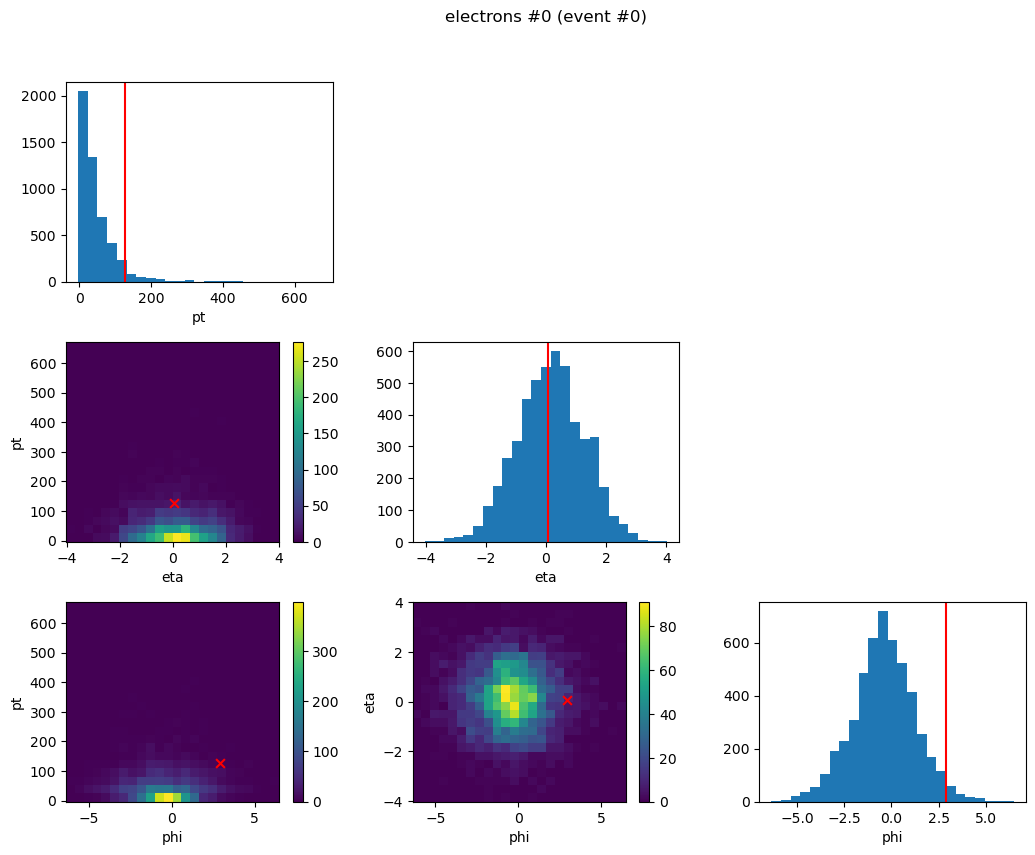

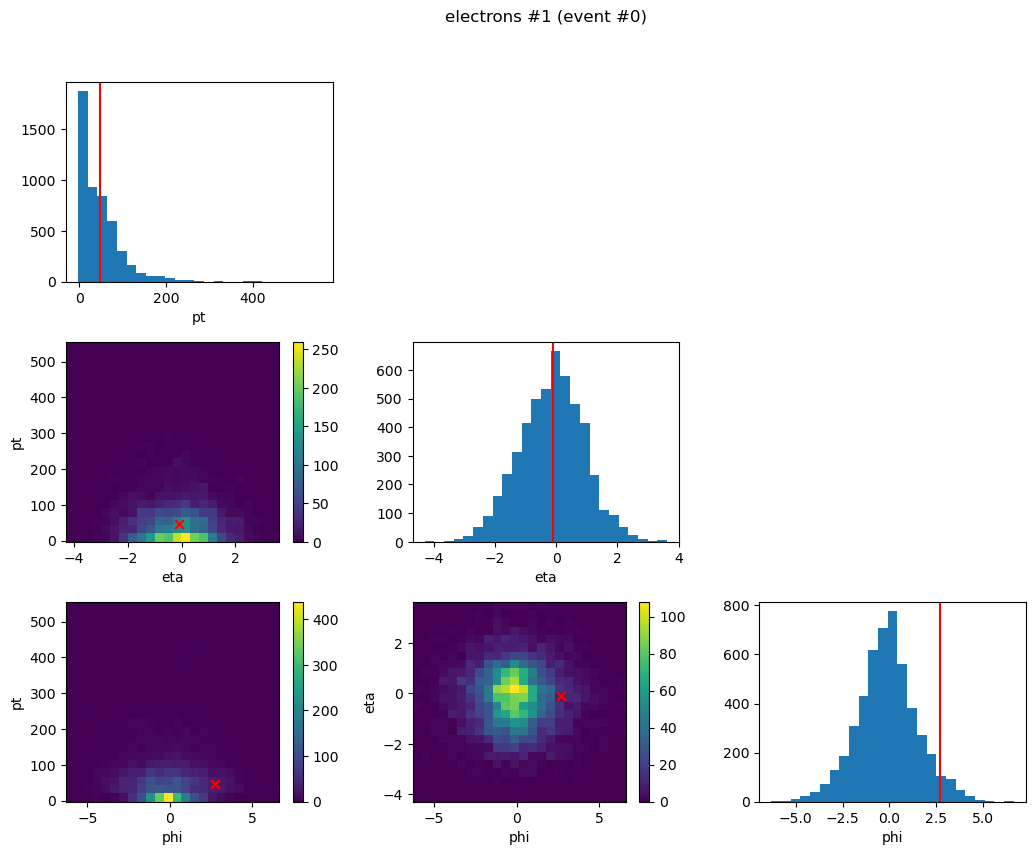

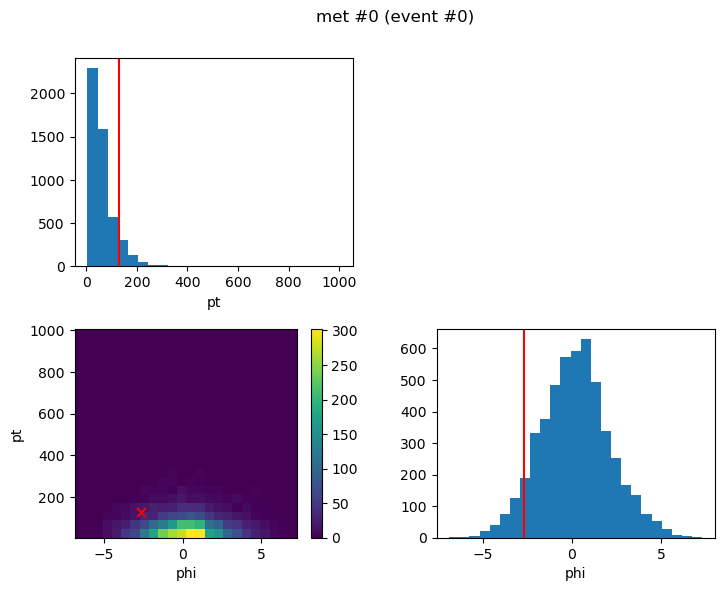

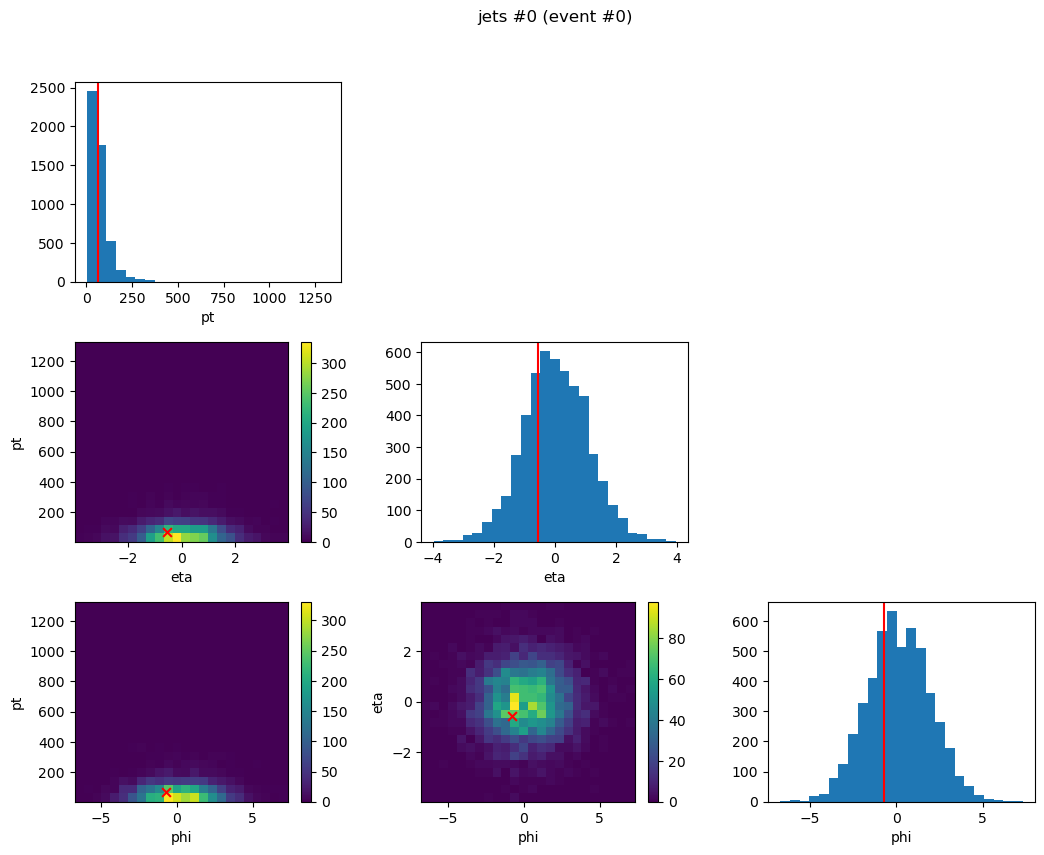

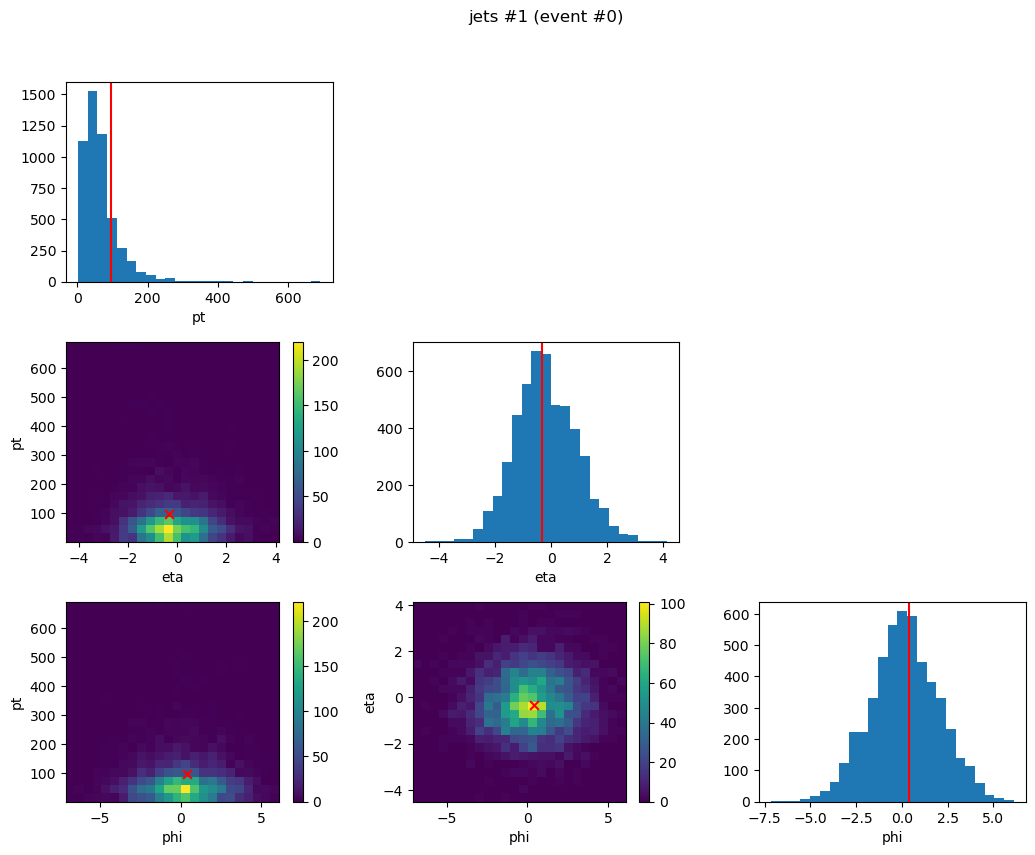

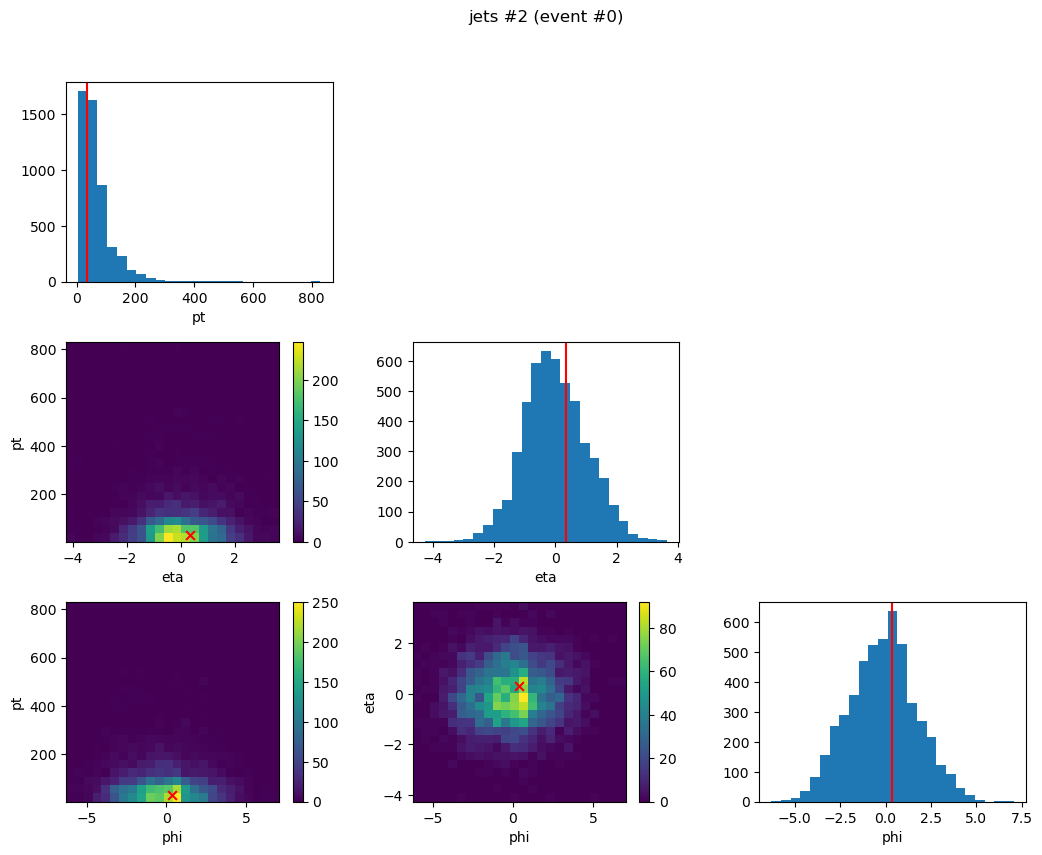

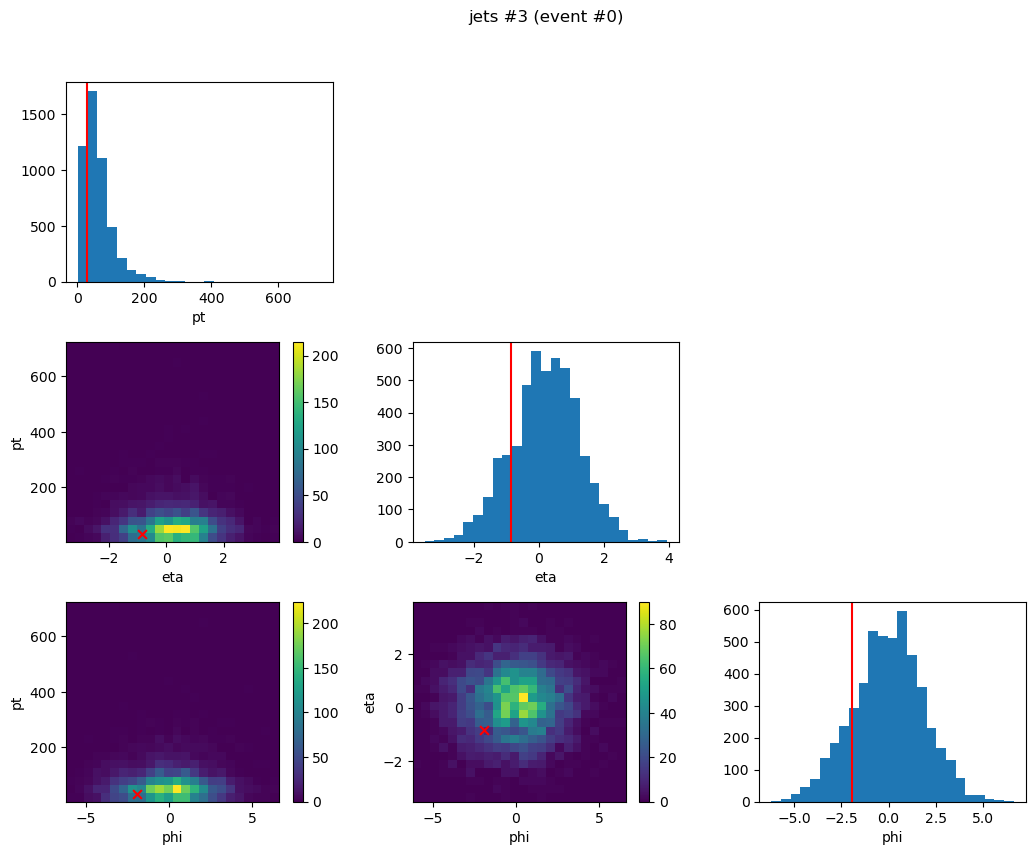

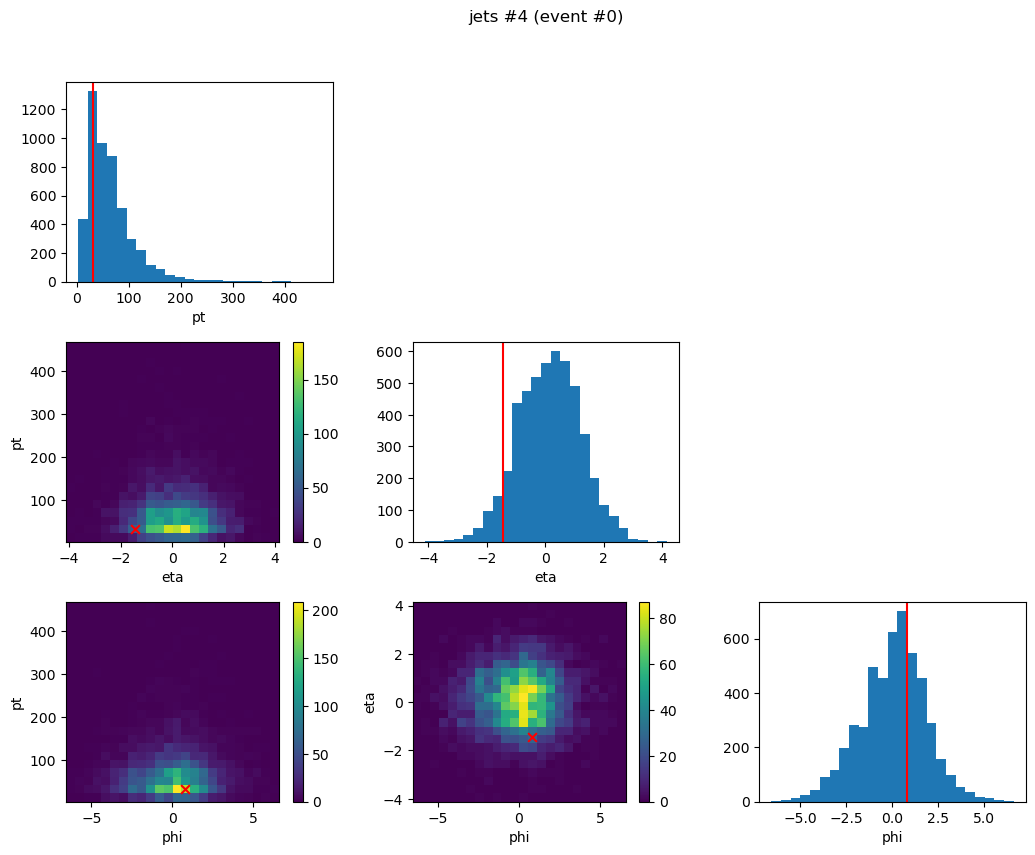

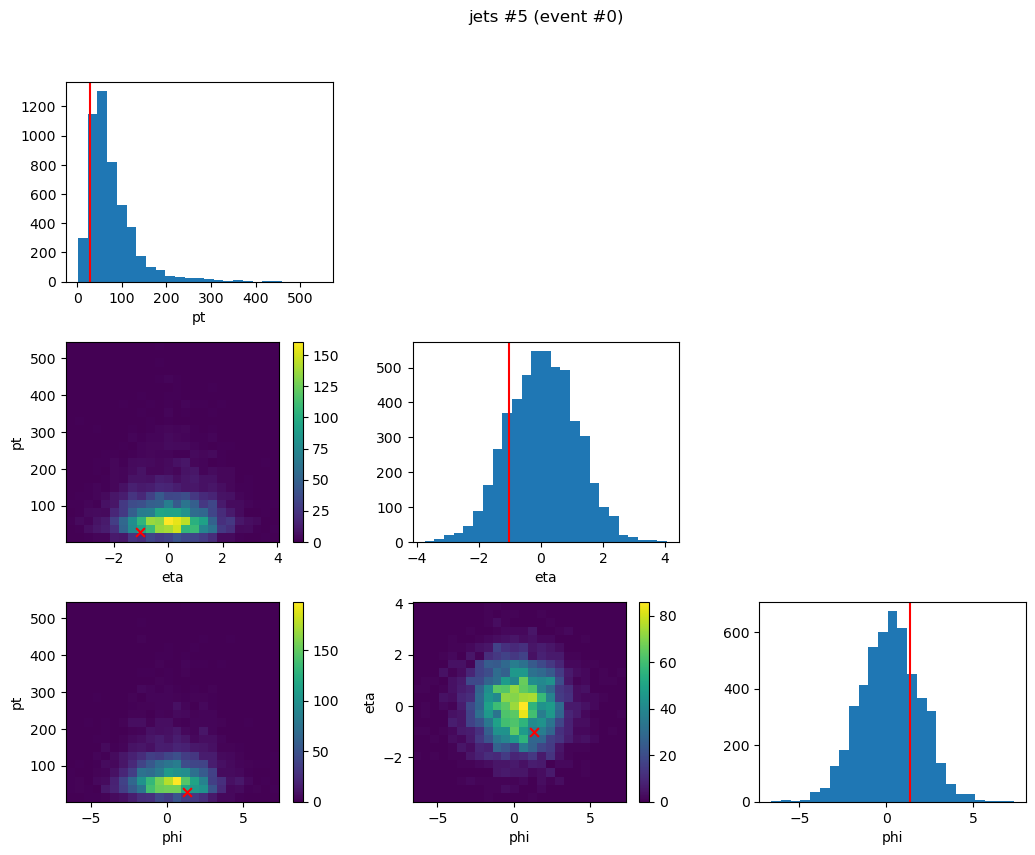

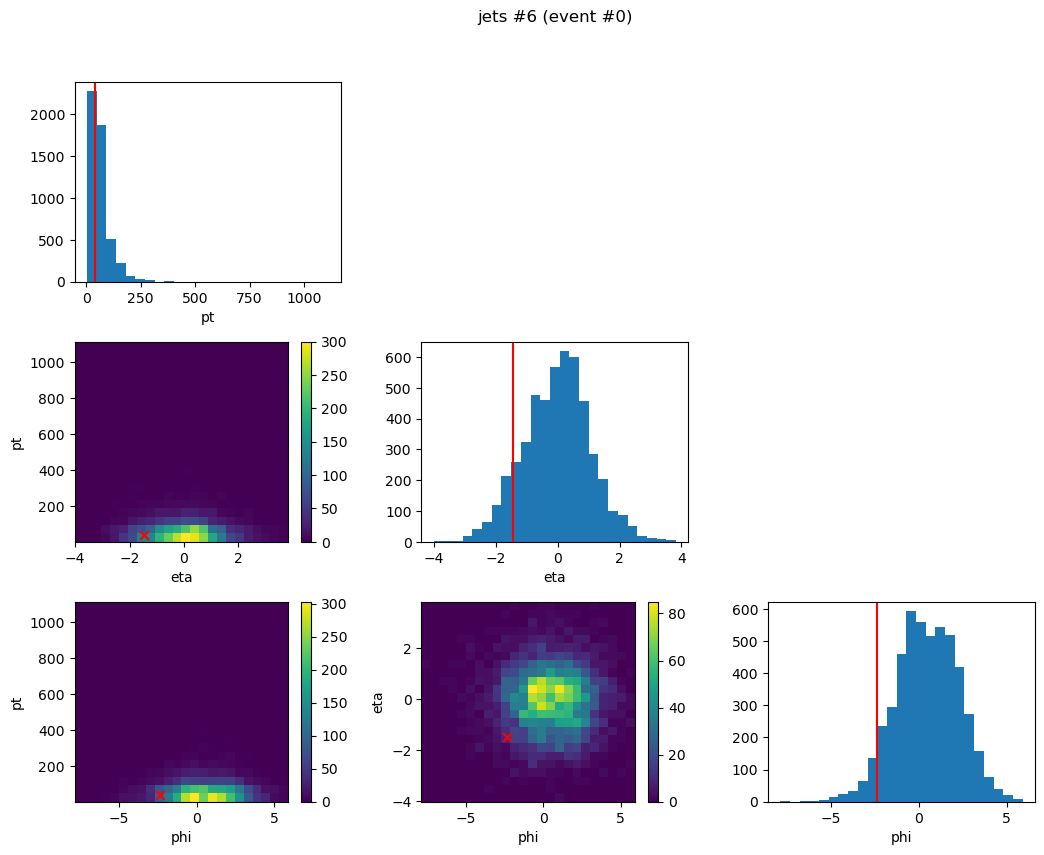

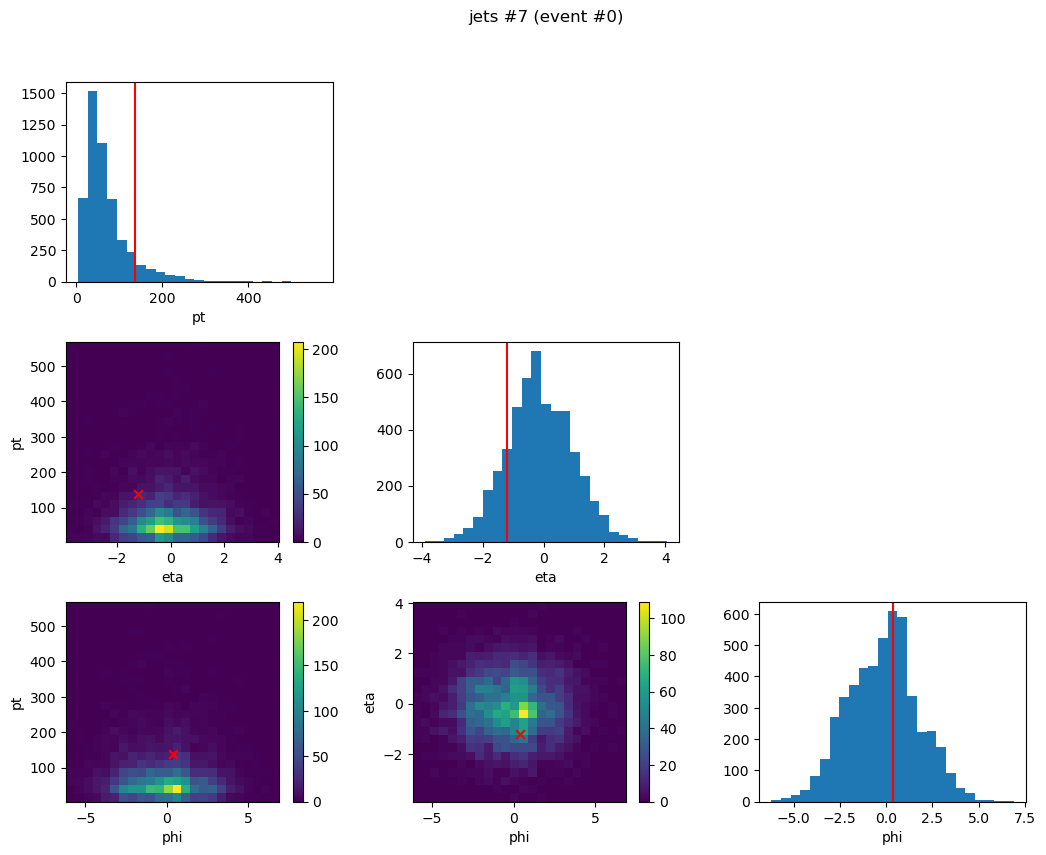

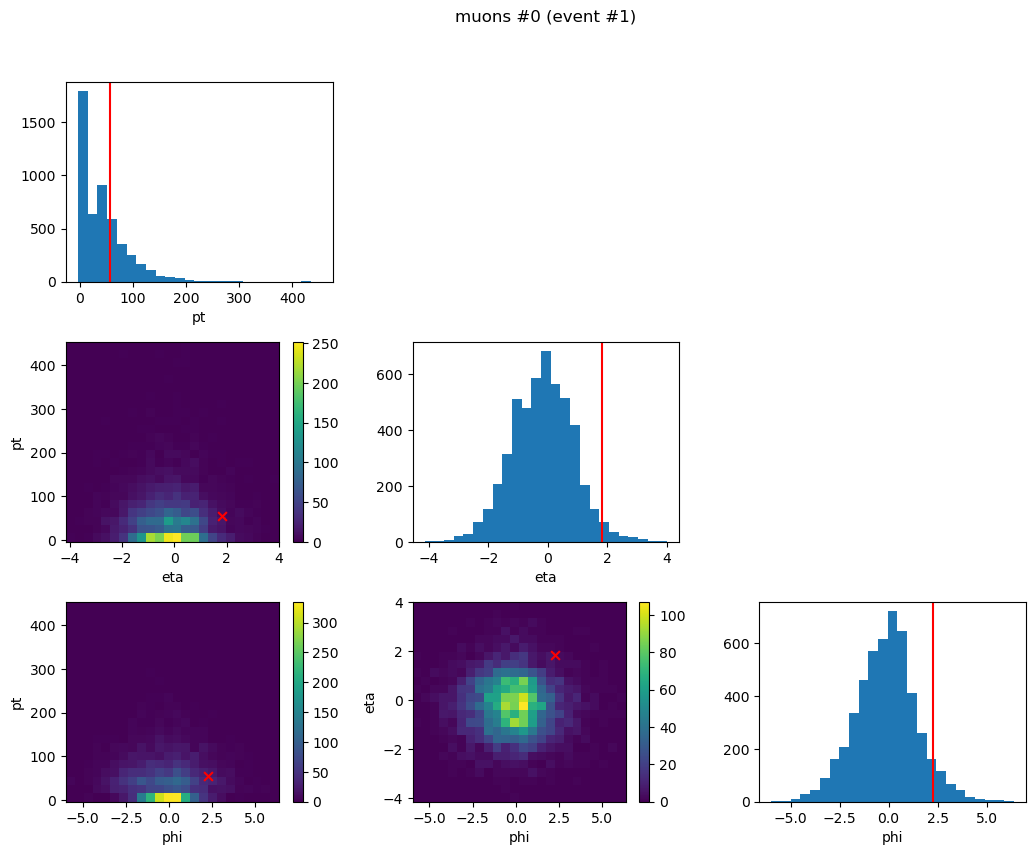

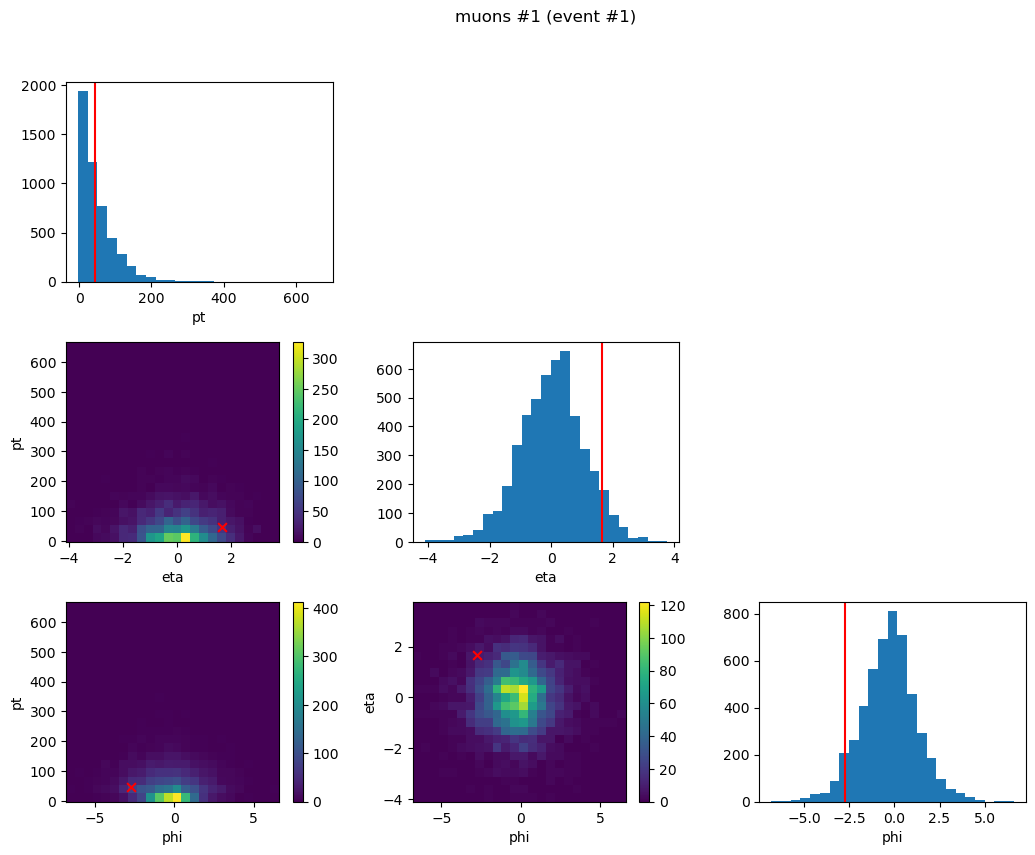

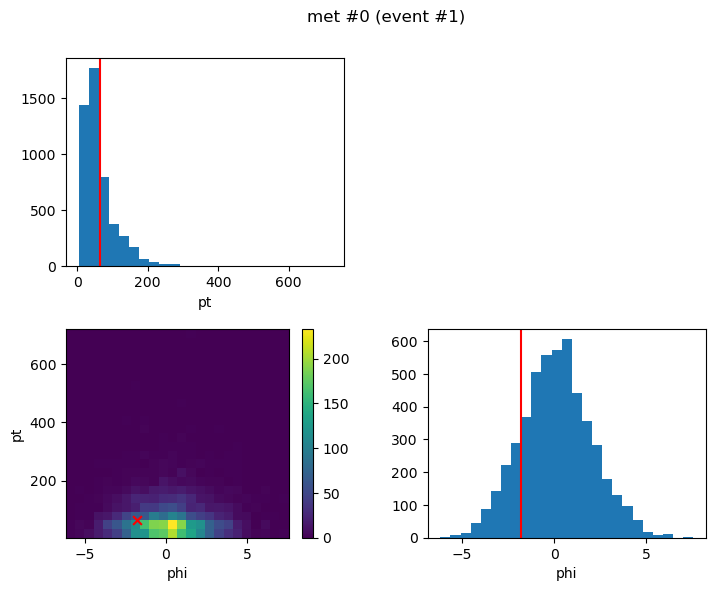

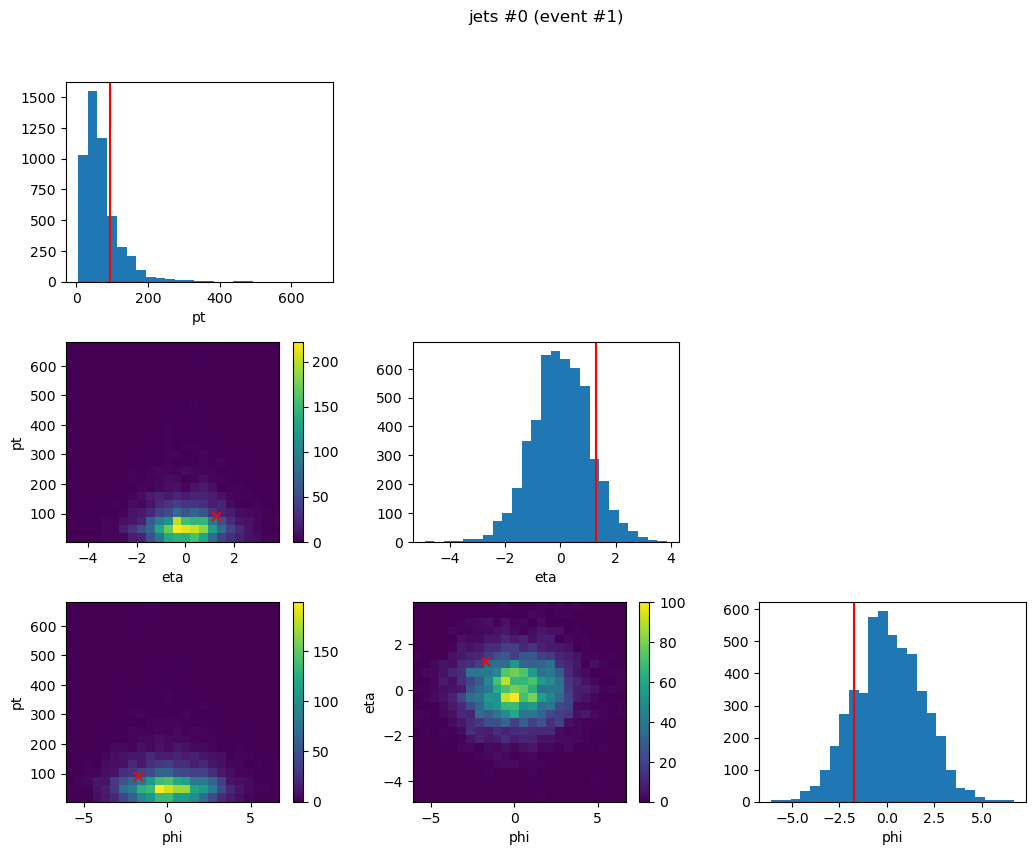

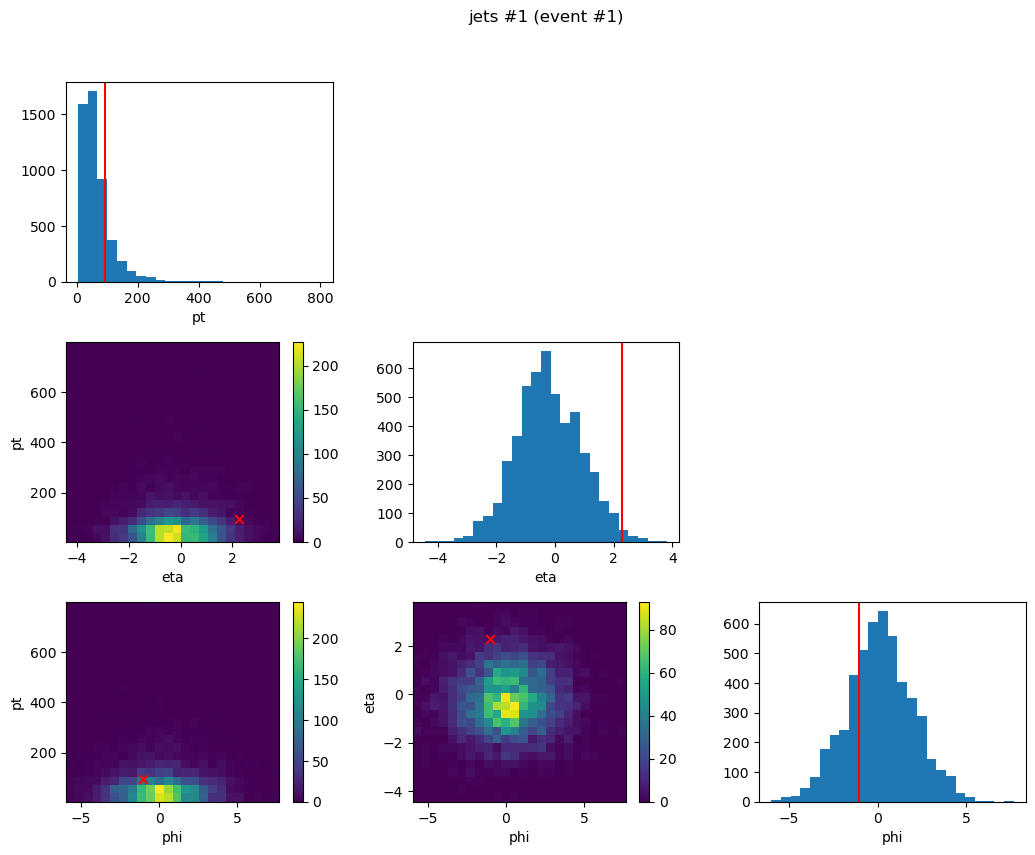

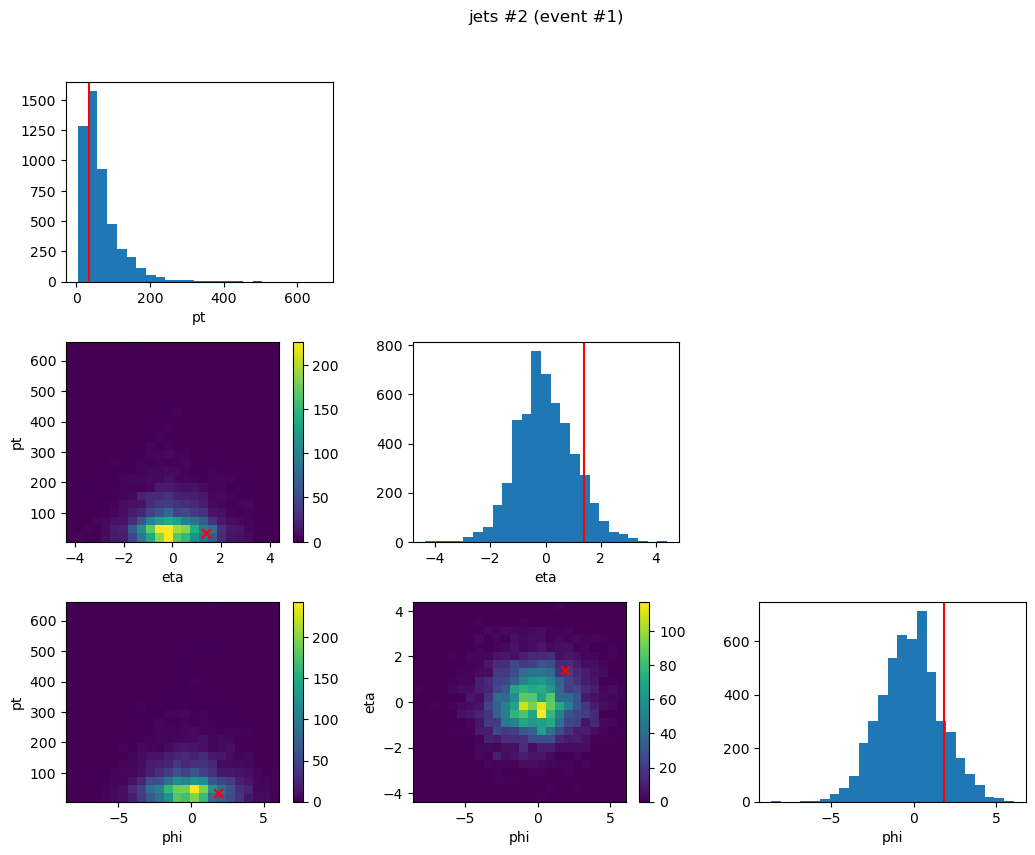

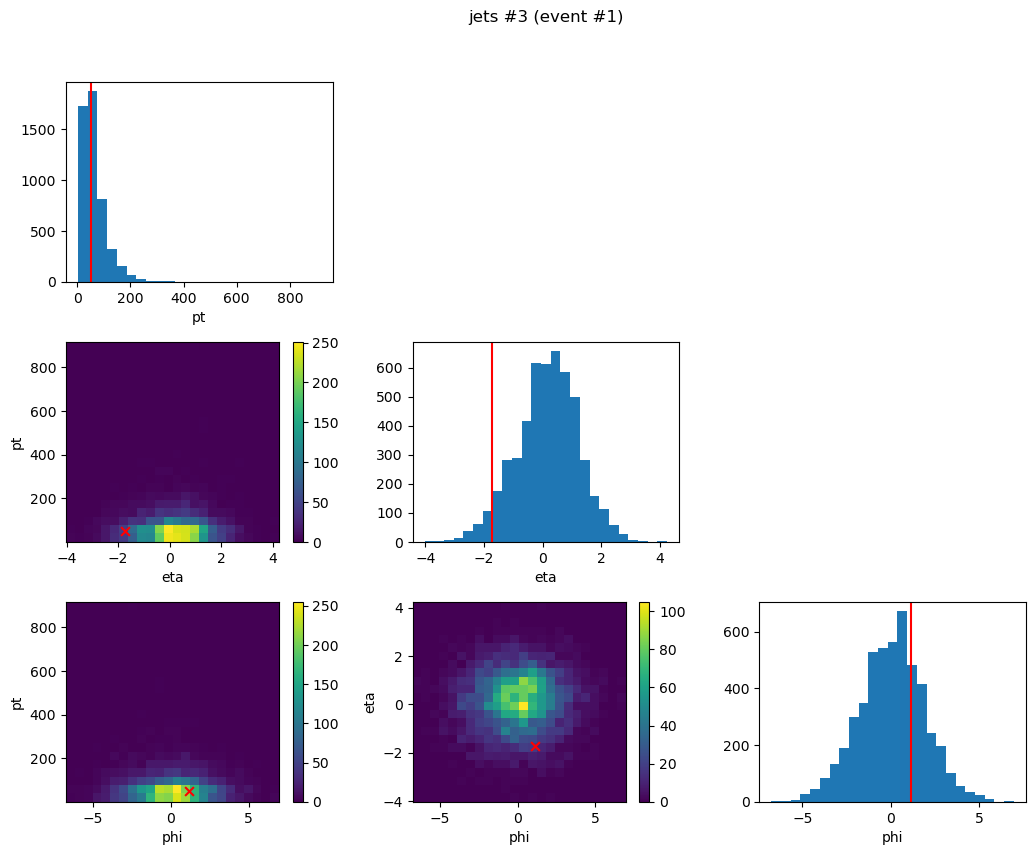

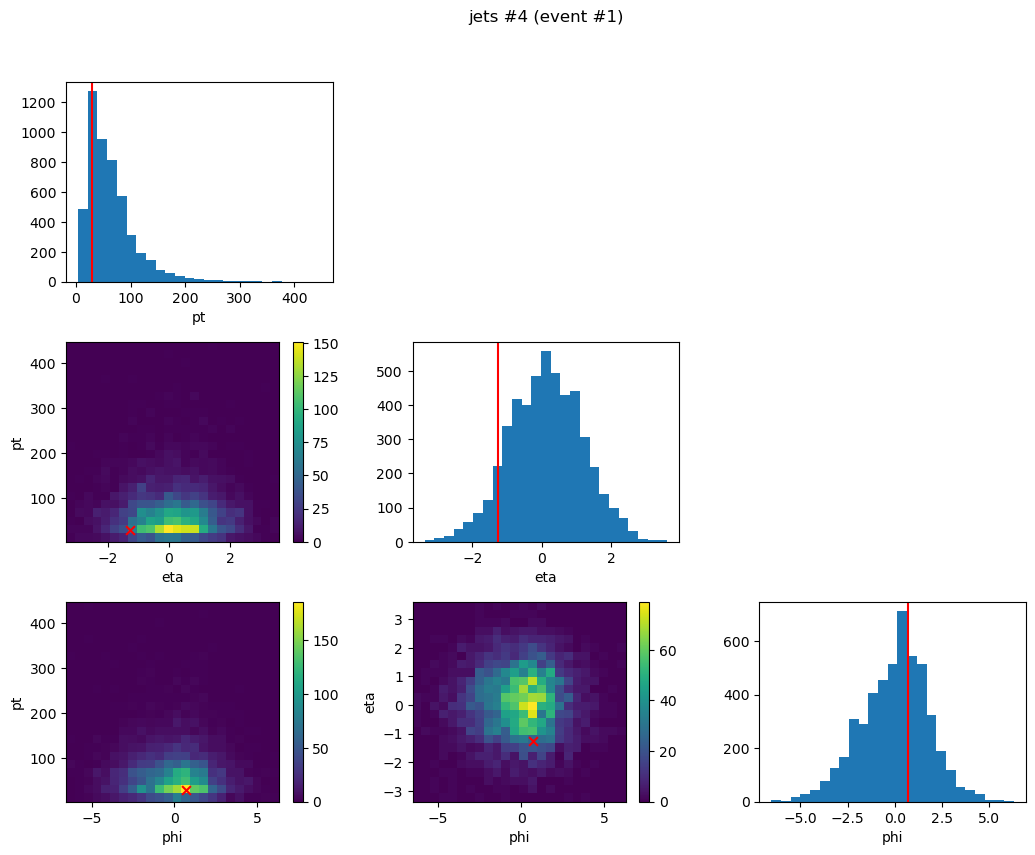

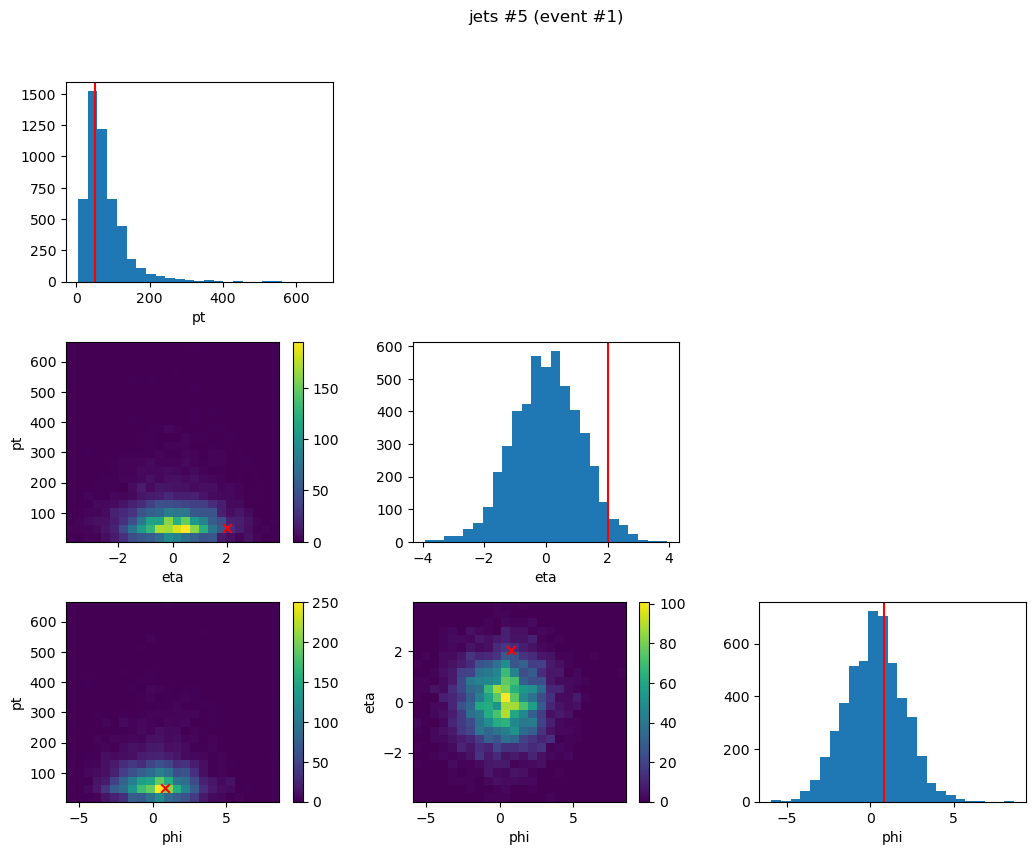

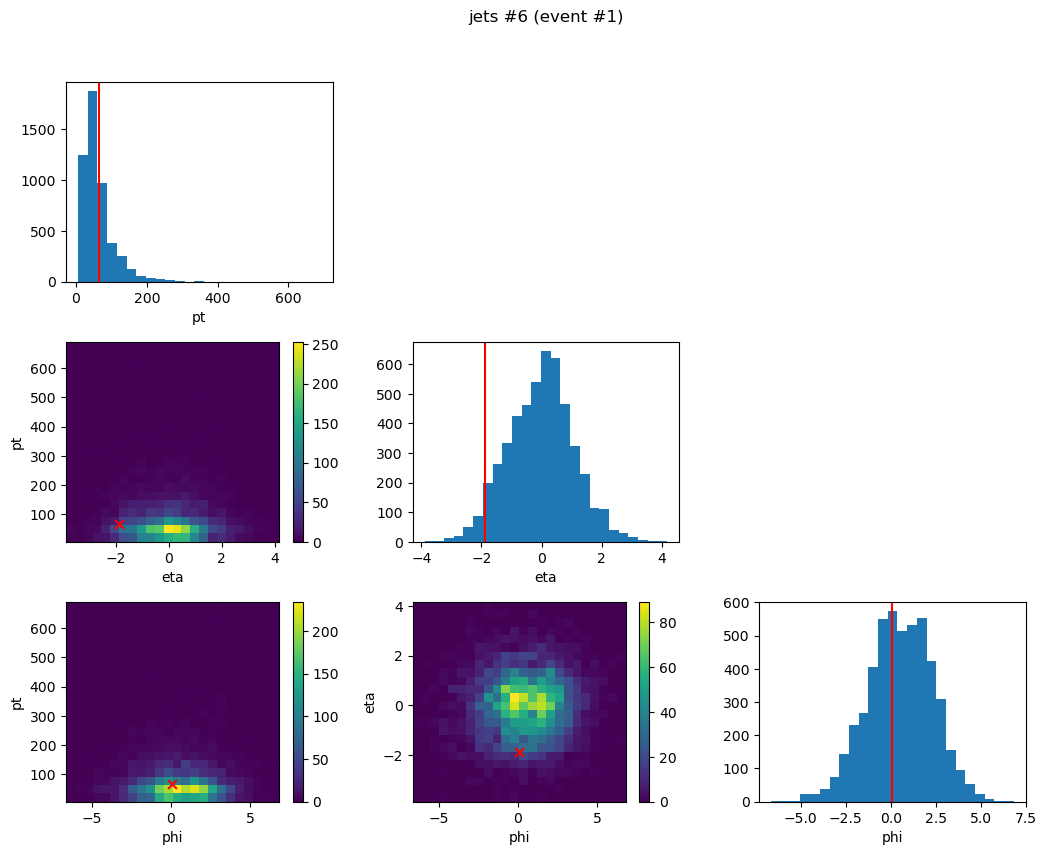

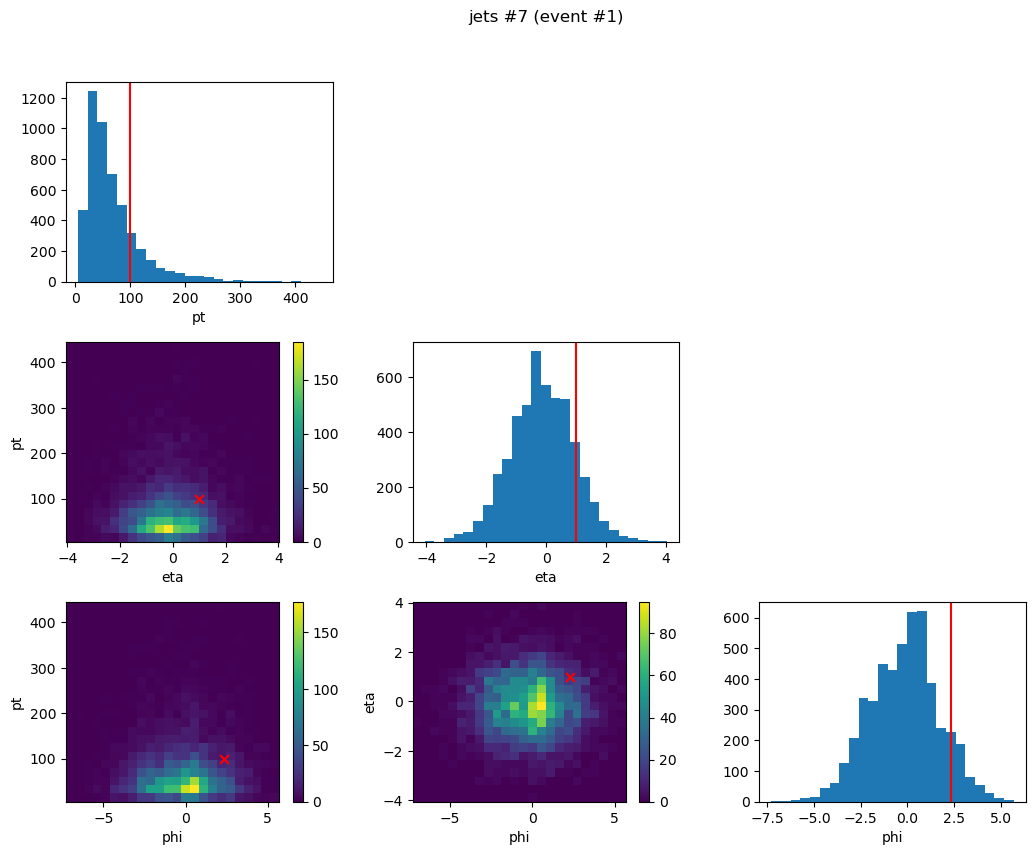

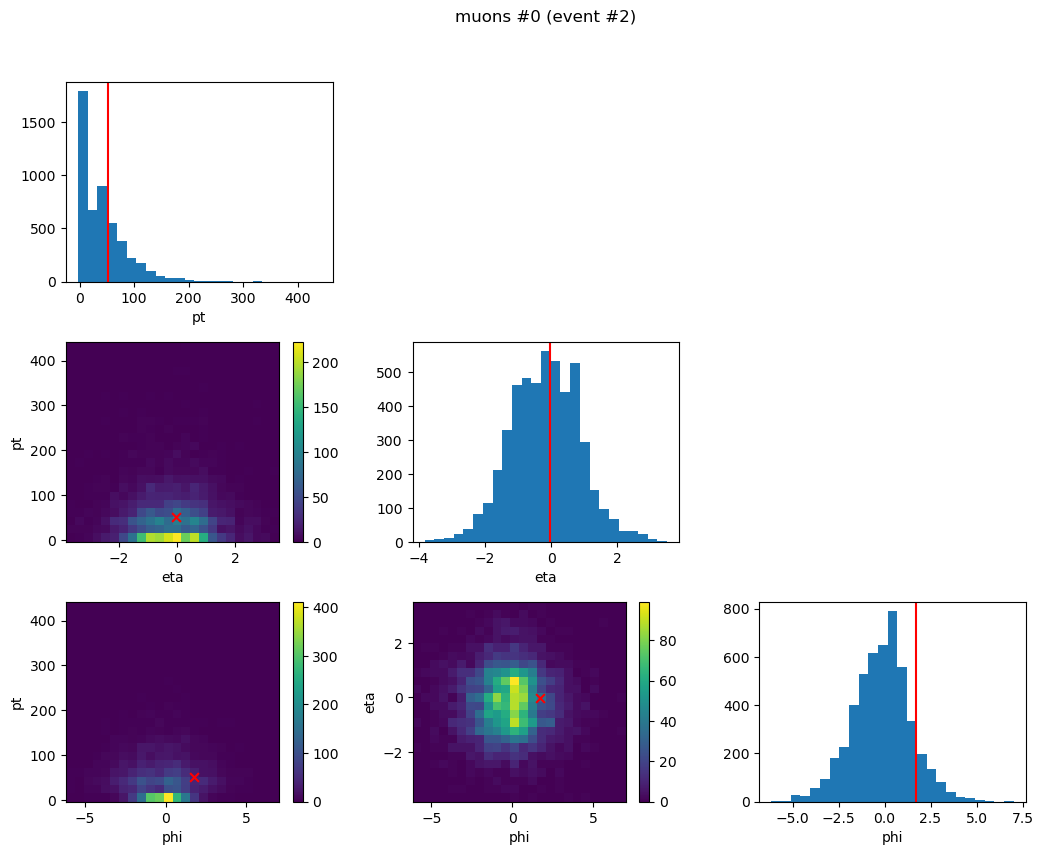

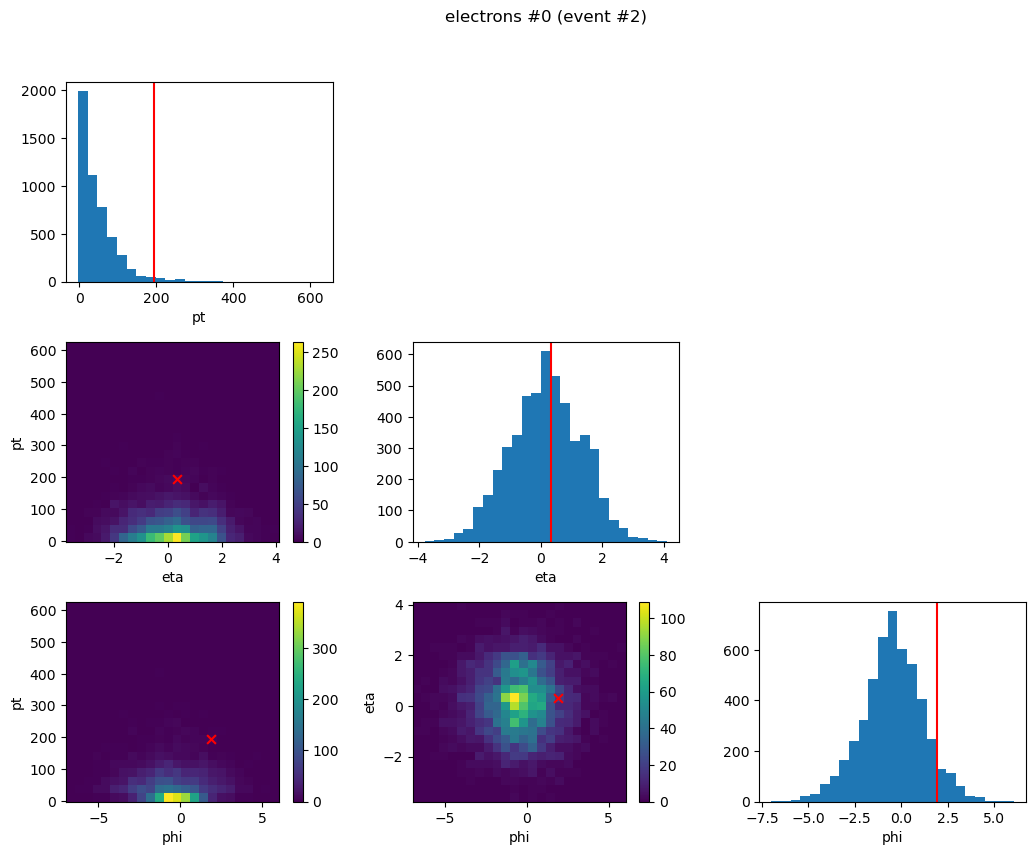

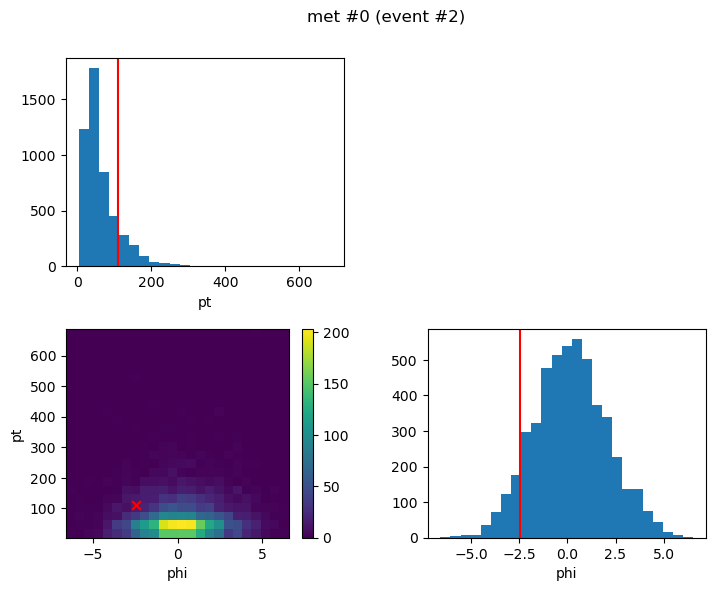

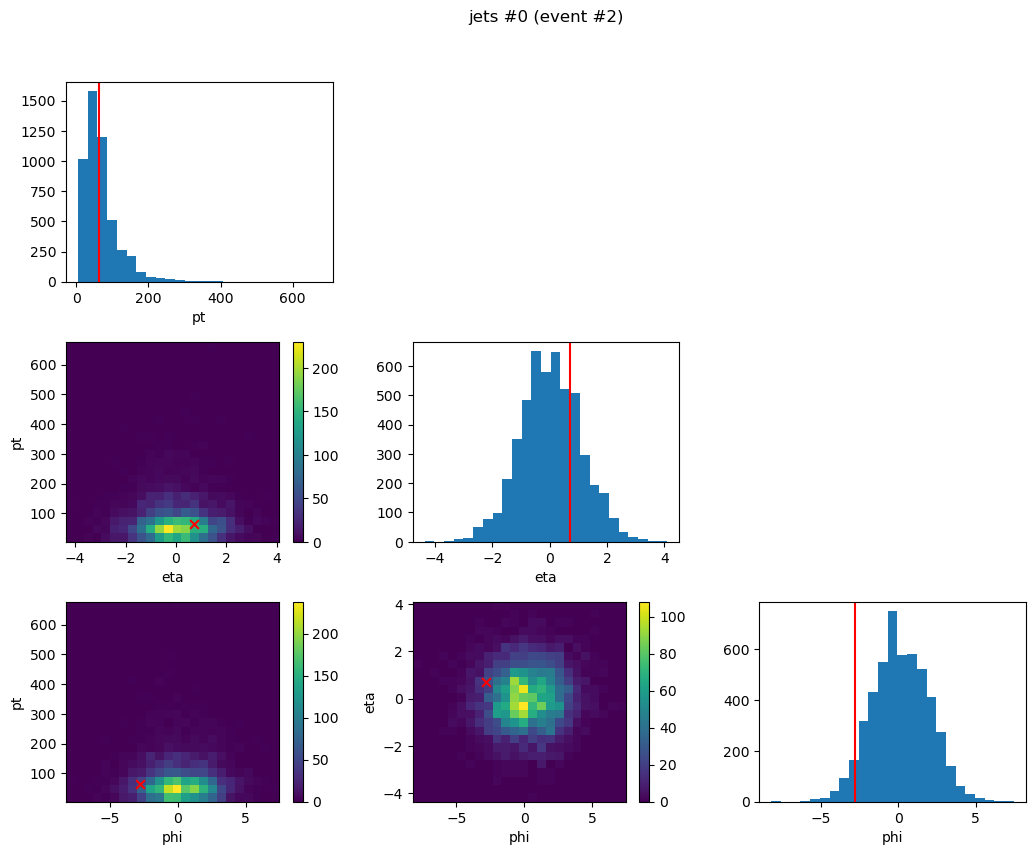

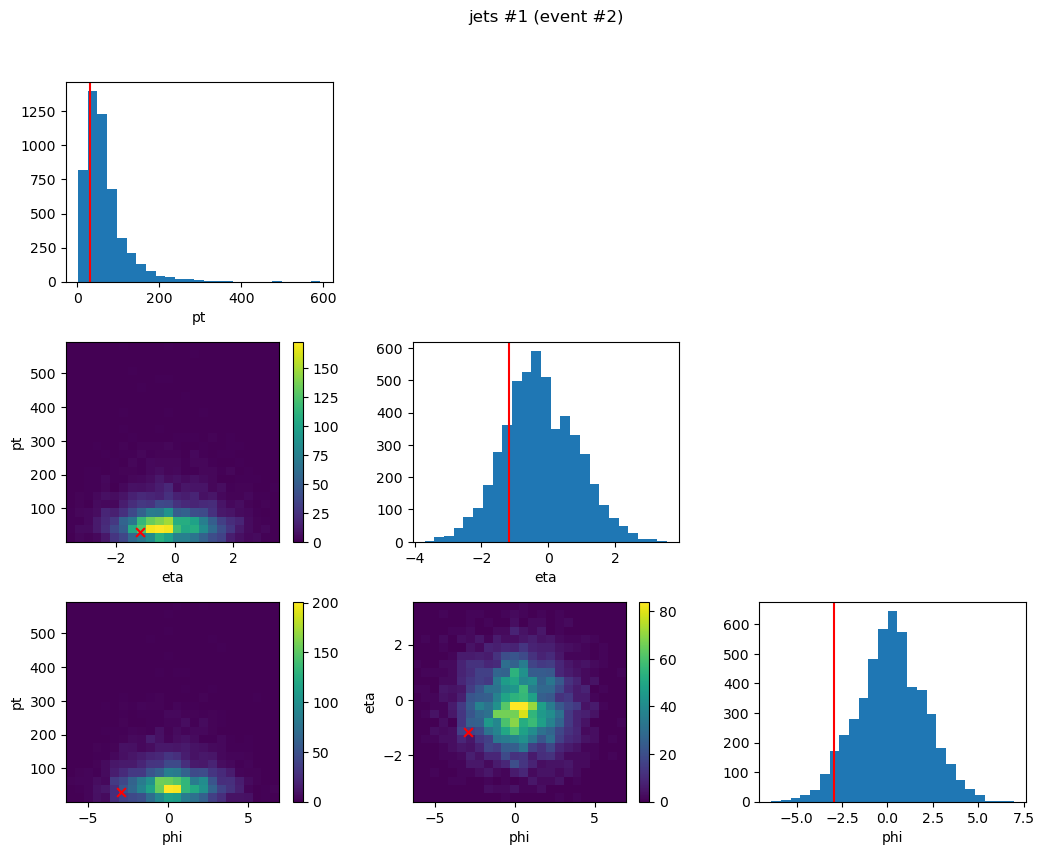

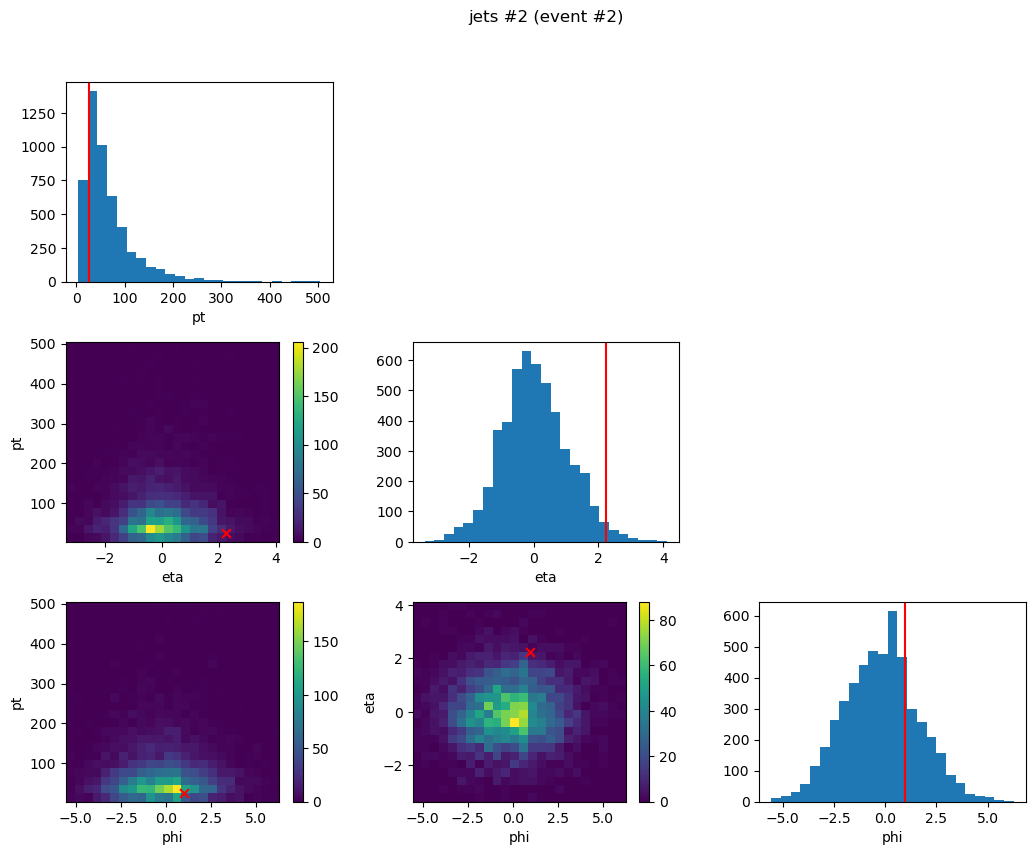

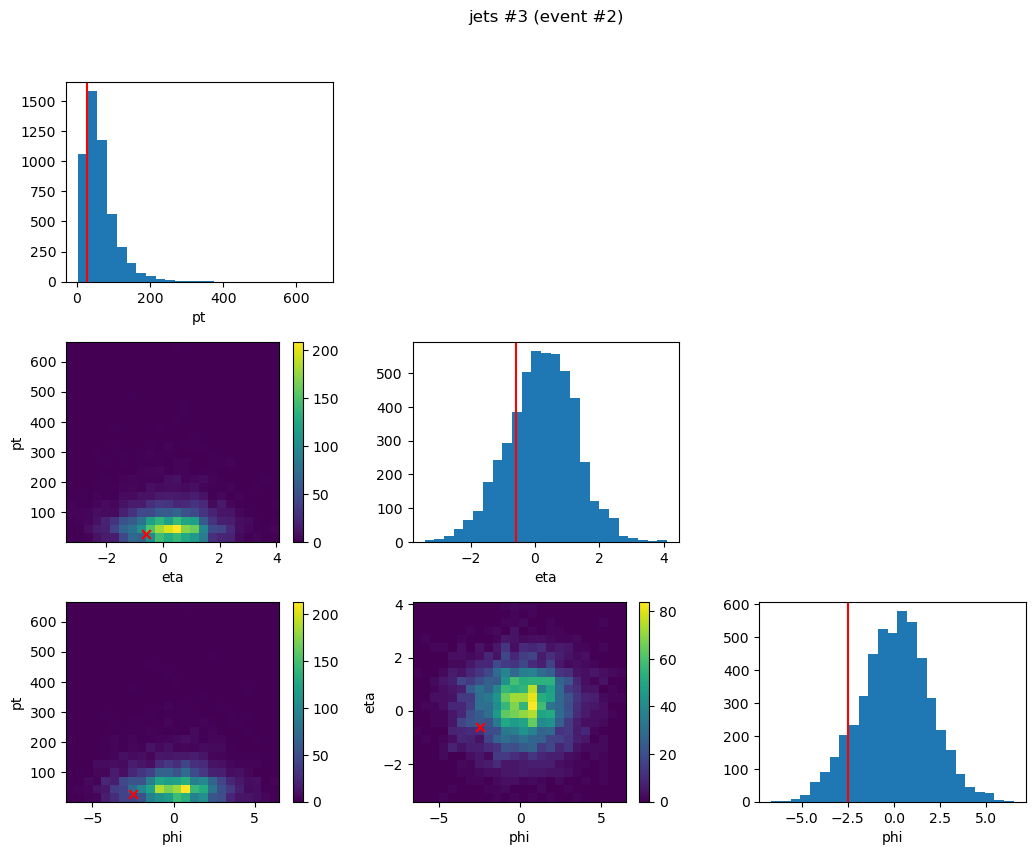

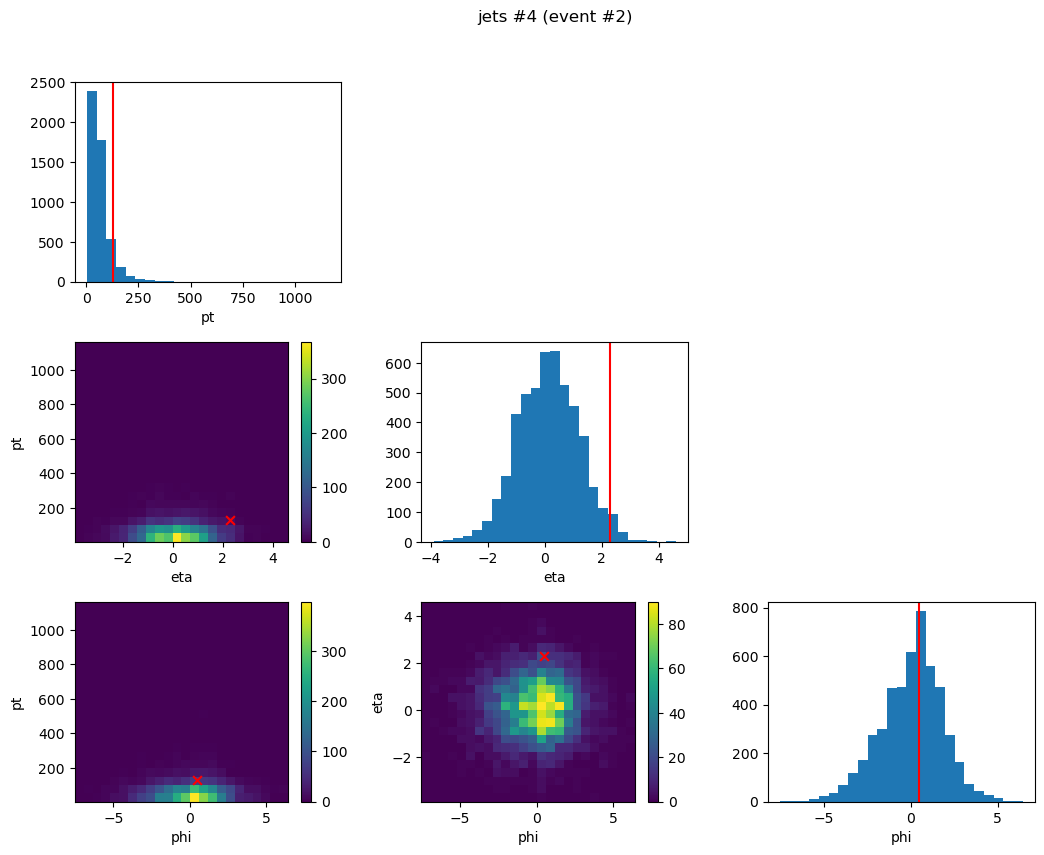

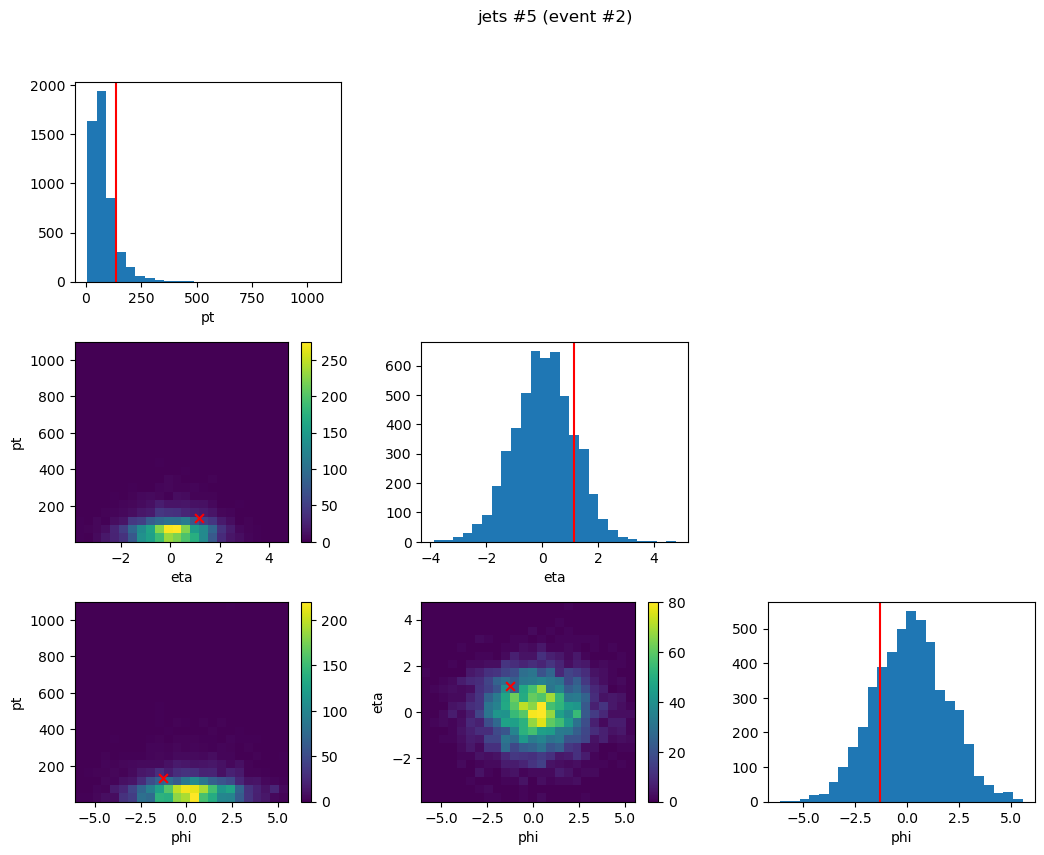

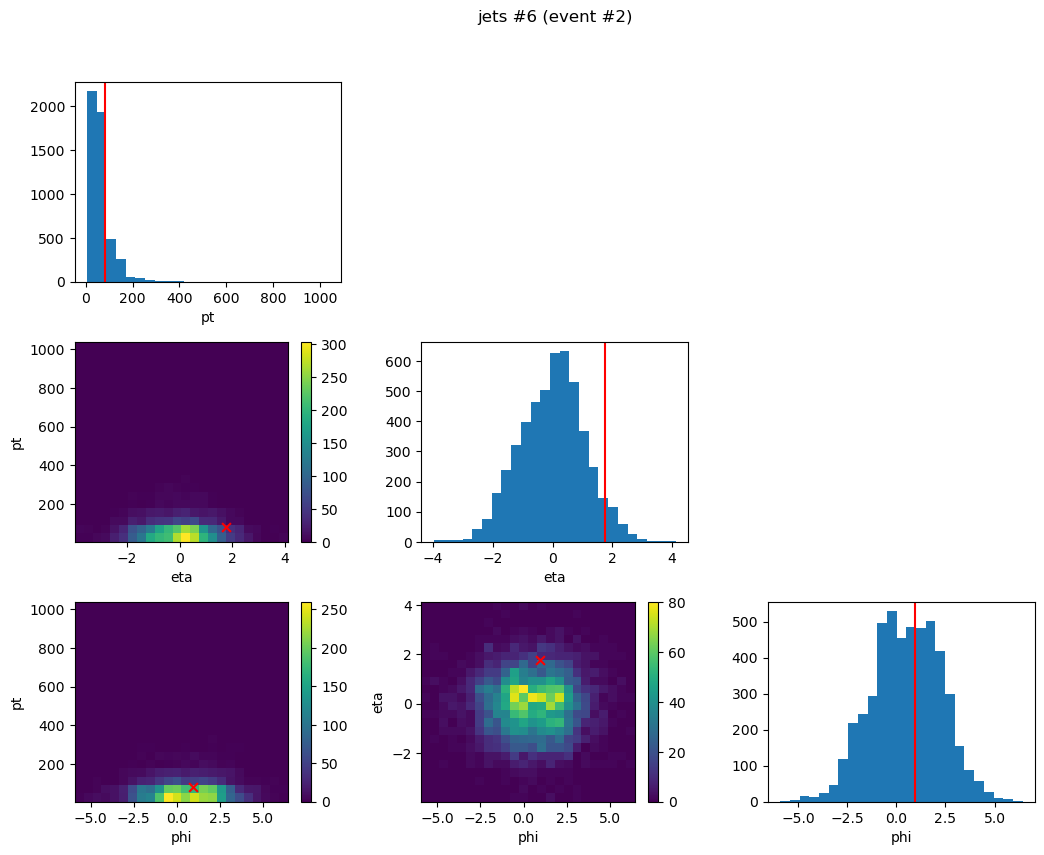

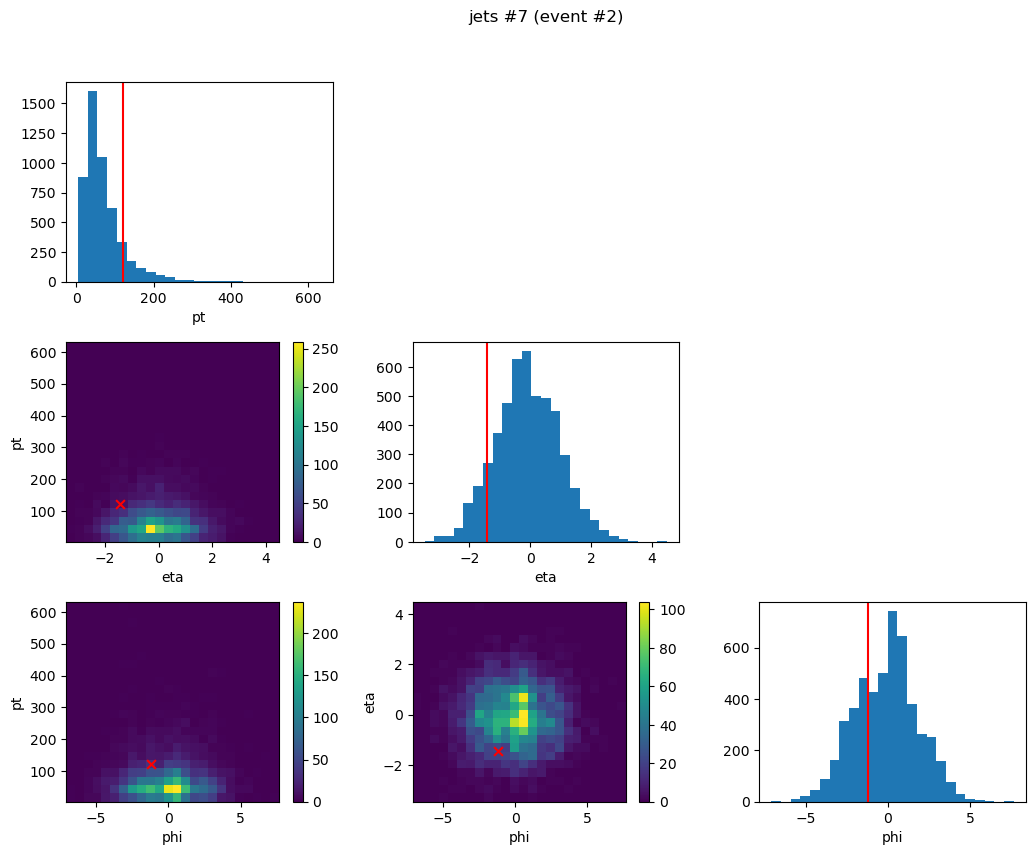

{'event_0_obj_electrons_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_electrons_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_0_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_2': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_3': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_4': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_5': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_6': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_7': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_1_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_2': <Figure siz

In [17]:
sampling = SamplingCallback(
    comb_dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 5000, 
    frequency = 1,
    raw = True,
    bins = 25,
    log_scale = False,
)

sampling.make_sampling_plots(model,show=True)

In [ ]:
##### Parameters #####
epochs = 1000
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-6)
model.set_optimizer(optimizer)

##### Scheduler #####
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer = optimizer, 
#     max_lr = 1e-3, 
#     epochs = epochs, 
#     steps_per_epoch = steps_per_epoch_train, 
#     pct_start = 0.20, 
#     anneal_strategy='cos', 
#     cycle_momentum=True, 
#     base_momentum=0.85, 
#     max_momentum=0.95, 
#     div_factor=1e3, 
#     final_div_factor=1e5,
# )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=20, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=5, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'HH',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)



Training   : Batch size = 256 => 34 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/87ddb91701394bdf925a33b0c16d01e4

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                                                            | 0/? [00:00<?, …

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |                                                                                   | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

COMET ERROR: File upload failed: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='www.comet.com', port=443): Read timed out. (read timeout=900)")), file: /scratch/fbury/52480597/tmpy0pb4cjj.svg, url: 'https://www.comet.com/clientlib/visualizations/upload', max retries: 4


Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

In [ ]:
sampling.make_sampling_plots(model,show=True)